## Mexico City Subsidence, Mexico (2016)

See also:

TRAINING KIT – HAZA03

LAND SUBSIDENCE WITH SENTINEL-1 using SNAP

https://eo4society.esa.int/wp-content/uploads/2022/01/HAZA03_Land-Subsidence_Mexico-city.pdf

The PyGMTSAR InSAR library, Geomed3D Geophysical Inversion Library, N-Cube 3D/4D GIS Data Visualization, among others, are my open-source projects developed in my free time. I hold a Master's degree in STEM, specializing in radio physics. In 2004, I received the first prize in the All-Russian Physics Competition for significant results in forward and inverse modeling for nonlinear optics and holography. These skills are also applicable to modeling Gravity, Magnetic, and Thermal fields, as well as satellite interferometry processing. With 20 years of experience as a data scientist and software developer, I have contributed to scientific and industrial development, working on government contracts, university projects, and with companies like LG Corp and Google Inc.

You can support my work on [Patreon](https://www.patreon.com/pechnikov), where I share updates on my projects, publications, use cases, examples, and other useful information. For research and development services and support, please visit my profile on the freelance platform [Upwork](https://www.upwork.com).

### Resources
- Google Colab Pro notebooks and articles on [Patreon](https://www.patreon.com/pechnikov),
- Google Colab notebooks on [GitHub](https://github.com),
- Docker Images on [DockerHub](https://hub.docker.com),
- Geological Models on [YouTube](https://www.youtube.com),
- VR/AR Geological Models on [GitHub](https://github.com),
- Live updates and announcements on [LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/).

© Alexey Pechnikov, 2025

$\large\color{blue}{\text{Hint: Use menu Cell} \to \text{Run All or Runtime} \to \text{Complete All or Runtime} \to \text{Run All}}$
$\large\color{blue}{\text{(depending of your localization settings) to execute the entire notebook}}$

## Google Colab Installation

Install PyGMTSAR and required GMTSAR binaries (including SNAPHU)

In [79]:
import platform, sys, os                                                                                                #standard system libraries
if 'google.colab' in sys.modules:
    # install PyGMTSAR stable version from PyPI
    !{sys.executable} -m pip install -q pygmtsar                                                                        #stable version of pygmtsar
    # alternatively, nstall PyGMTSAR development version from GitHub
    #!{sys.executable} -m pip install -Uq git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar
    # use PyGMTSAR Google Colab installation script to install binary dependencies
    # script URL: https://github.com/AlexeyPechnikov/pygmtsar/blob/pygmtsar2/pygmtsar/pygmtsar/data/google_colab.sh
    import importlib.resources as resources                                                                             #to work with package resources (e.g., .sh scripts)
    with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:
        # Execute the script and capture the output
        import subprocess
        process = subprocess.run(['sh', google_colab_script_filename], capture_output=True, text=True, env=os.environ) # Pass current environment
        print(process.stdout)
        print(process.stderr)

    # After the script runs, GMTSAR should be installed in /usr/local/GMTSAR
    # Add the GMTSAR bin directory to the PATH environment variable permanently
    os.environ['PATH'] = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    # Also update the PATH for the current Python process
    sys.path.append('/usr/local/GMTSAR/bin/')

    # enable custom widget manager as required by recent Google Colab updates
    from google.colab import output
    output.enable_custom_widget_manager()                                                                               #enable Colab’s custom widget manager
    # initialize virtual framebuffer for interactive 3D visualization; required for headless environments
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)                                                                   # initialize a virtual framebuffer for headless rendering
    display.start()                                                                                                     #start the framebuffer

# display PyGMTSAR version
from pygmtsar import __version__
__version__

'2025.4.8.post1'

In [23]:
    #with resources.as_file(resources.files('pygmtsar.data') / 'google_colab.sh') as google_colab_script_filename:    #it was code used to check if GMTSAR was allright
       # !sh {google_colab_script_filename}

## Load and Setup Python Modules

In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client                               # cluster for parallel computations
import dask                                                       # computing on large datasets

In [93]:
# plotting modules
import pyvista as pv                                              #visualisation for meshes, point clouds etc
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension(comms='ipywidgets')
panel.extension('vtk')                                            #extension for 3D viewers
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]                          #default matplotlib appearance
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline                                                #just to render inside jupyter

In [4]:
# define Pandas display settings
pd.set_option('display.max_rows', None)                          #display all rows
pd.set_option('display.max_columns', None)                       #display all columns
pd.set_option('display.width', None)                             #use full notebook width
pd.set_option('display.max_colwidth', 100)                       #maxwidth 100 char

In [5]:
from pygmtsar import S1, Stack, tqdm_dask, ASF, Tiles
# S1  class to manage Sentinel-1 metadata (scenes, bursts)
# Stack  to handle interferometric stacks (multiple acquisitions, time-series)
# tqdm_dask  progress bar for Dask
# ASF  functions to interact with Alaska Satellite Facility
# Tiles  to manage tiling of large scenes


## Define 3 Sentinel-1 SLC Scenes and Processing Parameters

https://search.asf.alaska.edu/#/?zoom=8.845&center=-98.862,18.655&view=equatorial&polygon=LINESTRING(-99.1139%2019.5348,-99.0777%2019.0994)&start=2016-06-05T17:00:00Z&end=2016-09-10T16:59:59Z&resultsLoaded=true&granule=S1_305967_IW3_20160910T122552_VV_76D7-BURST&flightDirs=Descending&dataset=SENTINEL-1%20BURSTS&path=143-143

### Descending Orbit Configuration

In [ ]:
BURSTS = """
S1_305968_IW3_20160910T122555_VV_76D7-BURST
S1_305967_IW3_20160910T122552_VV_76D7-BURST
S1_305966_IW3_20160910T122550_VV_76D7-BURST
S1_305968_IW3_20160606T122550_VV_E555-BURST
S1_305967_IW3_20160606T122547_VV_E555-BURST
S1_305966_IW3_20160606T122545_VV_E555-BURST
"""
BURSTS = list(filter(None, BURSTS.split('\n')))   #we use vv (not vh) because of lower noise and vh is bad for measuring deformation

print (f'Bursts defined: {len(BURSTS)}') #how many were defined

Bursts defined: 6


In [7]:
WORKDIR      = 'raw_mexico'         #intermediate results get here
DATADIR      = 'data_mexico'        #contains Sen1 data

In [8]:
# define DEM and landmask filenames inside data directory
DEM = f'{DATADIR}/dem.nc'                             #DEM to provide thopographic reference for phase correction

## Download and Unpack Datasets

## Enter Your ASF User and Password

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated.

In [9]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf_username = 'GoogleColab2023'
asf_password = 'GoogleColab_2023'

In [10]:
# Set these variables to None and you will be prompted to enter your username and password below.
asf = ASF(asf_username, asf_password)                   #this creates ASF client
print(asf.download(DATADIR, BURSTS))

ASF Downloading Bursts Catalog:   0%|          | 0/1 [00:00<?, ?it/s]

ASF Downloading Sentinel-1 SLC Bursts:   0%|          | 0/6 [00:00<?, ?it/s]

                                burst_or_scene
0  S1_305968_IW3_20160910T122555_VV_76D7-BURST
1  S1_305967_IW3_20160910T122552_VV_76D7-BURST
2  S1_305966_IW3_20160910T122550_VV_76D7-BURST
3  S1_305968_IW3_20160606T122550_VV_E555-BURST
4  S1_305967_IW3_20160606T122547_VV_E555-BURST
5  S1_305966_IW3_20160606T122545_VV_E555-BURST


In [11]:
# scan the data directory for SLC scenes and download missed orbits
S1.download_orbits(DATADIR, S1.scan_slc(DATADIR))           #it downloads all missed orbits (not these found in dir)

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


,orbit
0,S1A_OPER_AUX_POEORB_OPOD_20210312T064047_V20160605T225943_20160607T005943.EOF.zip
1,S1A_OPER_AUX_POEORB_OPOD_20210313T183500_V20160909T225943_20160911T005943.EOF.zip


NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


Tiles Parallel Downloading:   0%|          | 0/2 [00:00<?, ?it/s]

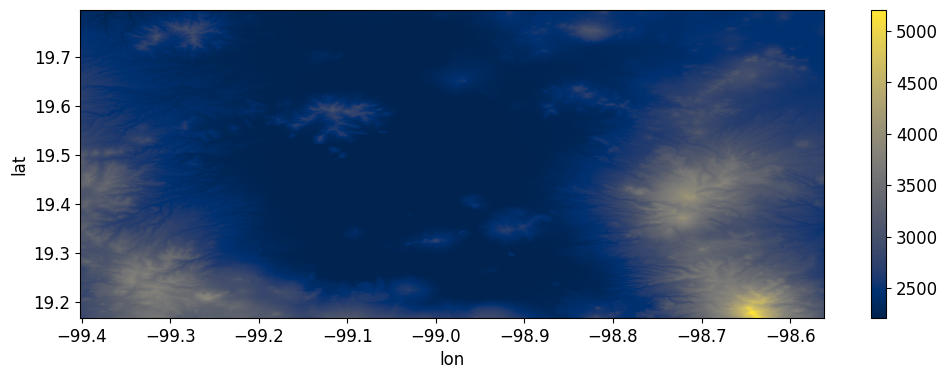

In [12]:
# download Copernicus Global DEM 1 arc-second (~30m)
# this DEM is needed to remove topographic phase in interferometry
Tiles().download_dem(S1.scan_slc(DATADIR), filename=DEM).plot.imshow(cmap='cividis')

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [105]:
# simple Dask initialization
if 'client' in globals():
    client.close()
import os
client = Client(processes=True, env=os.environ) # Pass the current environment to the workers
client

INFO:distributed.scheduler:Remove client Client-39713270-56ac-11f0-856e-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:57768; closing.
INFO:distributed.scheduler:Remove client Client-39713270-56ac-11f0-856e-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-39713270-56ac-11f0-856e-0242ac1c000c
INFO:distributed.scheduler:Retire worker addresses (stimulus_id='retire-workers-1751402058.626526') (0, 1)
INFO:distributed.scheduler:Remove client Client-worker-549a8960-56ac-11f0-9648-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:46122; closing.
INFO:distributed.scheduler:Remove client Client-worker-4ffe0c7d-56ac-11f0-964b-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:50846; closing.
INFO:distributed.scheduler:Remove client Client-worker-549a8960-56ac-11f0-9648-0242ac1c000c
INFO:distributed.scheduler:Remove client Client-worker-4ffe0c7d-56ac-11f0-964b-0242ac1c000c
INFO:distr

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 2,Total memory: 12.67 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:41853,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 2
Started: Just now,Total memory: 12.67 GiB
Comm: tcp://127.0.0.1:46259,Total threads: 1
Dashboard: http://127.0.0.1:34977/status,Memory: 6.34 GiB
Nanny: tcp://127.0.0.1:34855,


## Init SBAS

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

### Select Original Secenes and Download DEM and Orbits Later

Use filters to find required subswath, polarization and orbit in original scenes .SAFE directories in the data directory.

In [106]:
scenes = S1.scan_slc(DATADIR)             # it scans DATADIR for Sen1 SLC scenes and returns metadata

NOTE: Found multiple scenes for a single day, use function Stack.reframe() to stitch the scenes


In [107]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes) # assigns the list of SLC scenes to the stack
sbas.to_dataframe()

NOTE: auto set reference scene 2016-06-06. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,noisepath,calibpath,orbitpath,geometry
date,,,,,,,,,,,
2016-06-06,2016-06-06 12:25:45,D,S1A,VV,3,data_mexico/S1A_IW_SLC__1SSV_20160606T122545_20160606T122548_011590_011B5B_E555.SAFE/measurement...,data_mexico/S1A_IW_SLC__1SSV_20160606T122545_20160606T122548_011590_011B5B_E555.SAFE/annotation/...,None,None,data_mexico/S1A_OPER_AUX_POEORB_OPOD_20210312T064047_V20160605T225943_20160607T005943.EOF,"MULTIPOLYGON (((-98.56238 19.66591, -98.60092 19.67275, -98.63929 19.67955, -98.6775 19.6863, -9..."
2016-06-06,2016-06-06 12:25:47,D,S1A,VV,3,data_mexico/S1A_IW_SLC__1SSV_20160606T122547_20160606T122550_011590_011B5B_E555.SAFE/measurement...,data_mexico/S1A_IW_SLC__1SSV_20160606T122547_20160606T122550_011590_011B5B_E555.SAFE/annotation/...,None,None,data_mexico/S1A_OPER_AUX_POEORB_OPOD_20210312T064047_V20160605T225943_20160607T005943.EOF,"MULTIPOLYGON (((-98.59542 19.49944, -98.63392 19.50628, -98.67225 19.51309, -98.71041 19.51985, ..."
2016-06-06,2016-06-06 12:25:50,D,S1A,VV,3,data_mexico/S1A_IW_SLC__1SSV_20160606T122550_20160606T122553_011590_011B5B_E555.SAFE/measurement...,data_mexico/S1A_IW_SLC__1SSV_20160606T122550_20160606T122553_011590_011B5B_E555.SAFE/annotation/...,None,None,data_mexico/S1A_OPER_AUX_POEORB_OPOD_20210312T064047_V20160605T225943_20160607T005943.EOF,"MULTIPOLYGON (((-98.62836 19.33346, -98.66681 19.34031, -98.7051 19.34712, -98.74323 19.35389, -..."
2016-09-10,2016-09-10 12:25:50,D,S1A,VV,3,data_mexico/S1A_IW_SLC__1SSV_20160910T122550_20160910T122553_012990_0148FA_76D7.SAFE/measurement...,data_mexico/S1A_IW_SLC__1SSV_20160910T122550_20160910T122553_012990_0148FA_76D7.SAFE/annotation/...,None,None,data_mexico/S1A_OPER_AUX_POEORB_OPOD_20210313T183500_V20160909T225943_20160911T005943.EOF,"MULTIPOLYGON (((-98.56162 19.66622, -98.60015 19.67305, -98.63852 19.67985, -98.67673 19.68661, ..."
2016-09-10,2016-09-10 12:25:52,D,S1A,VV,3,data_mexico/S1A_IW_SLC__1SSV_20160910T122552_20160910T122555_012990_0148FA_76D7.SAFE/measurement...,data_mexico/S1A_IW_SLC__1SSV_20160910T122552_20160910T122555_012990_0148FA_76D7.SAFE/annotation/...,None,None,data_mexico/S1A_OPER_AUX_POEORB_OPOD_20210313T183500_V20160909T225943_20160911T005943.EOF,"MULTIPOLYGON (((-98.59469 19.49962, -98.63318 19.50647, -98.67151 19.51327, -98.70968 19.52004, ..."
2016-09-10,2016-09-10 12:25:55,D,S1A,VV,3,data_mexico/S1A_IW_SLC__1SSV_20160910T122555_20160910T122558_012990_0148FA_76D7.SAFE/measurement...,data_mexico/S1A_IW_SLC__1SSV_20160910T122555_20160910T122558_012990_0148FA_76D7.SAFE/annotation/...,None,None,data_mexico/S1A_OPER_AUX_POEORB_OPOD_20210313T183500_V20160909T225943_20160911T005943.EOF,"MULTIPOLYGON (((-98.62763 19.33364, -98.66608 19.34049, -98.70437 19.3473, -98.7425 19.35408, -9..."


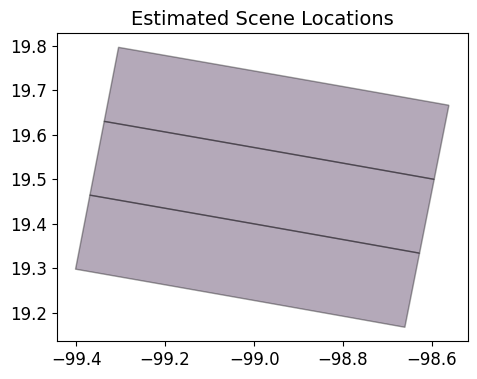

In [108]:
sbas.plot_scenes()

In [31]:
#that was to check if the paths were correct (to correct the bug)
# import os
# print(os.path.isdir("raw_mexico"))



True


## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

In [109]:
sbas.compute_reframe() #it merges multiple sequential frames and deletes the subswath (intersection)

Reframing:   0%|          | 0/2 [00:00<?, ?it/s]

### Load DEM

The function below loads DEM from file or Xarray variable and converts heights to ellipsoidal model using EGM96 grid.

In [111]:
# define the area of interest (AOI) to speedup the processing
sbas.load_dem(DEM)

NOTE: DEM exists, ignore the command. Use Stack.set_dem(None) to allow new DEM downloading


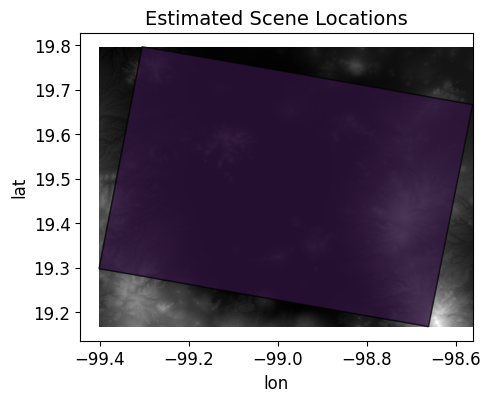

In [112]:
sbas.plot_scenes()                                    #outline of scene on DEM
plt.savefig('Estimated Scene Locations.jpg')

## Align Images

In [113]:
sbas.compute_align()              #it ensures all pixels are alligned for good interferogram generation

Preparing Reference:   0%|          | 0/1 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/1 [00:00<?, ?it/s]

## Geocoding Transform

In [114]:
# use 90m coordinates grid   (low resolution to speed up)
sbas.compute_geocode(coarsen=90.)

Radar Transform Computing:   0%|          | 0/1 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

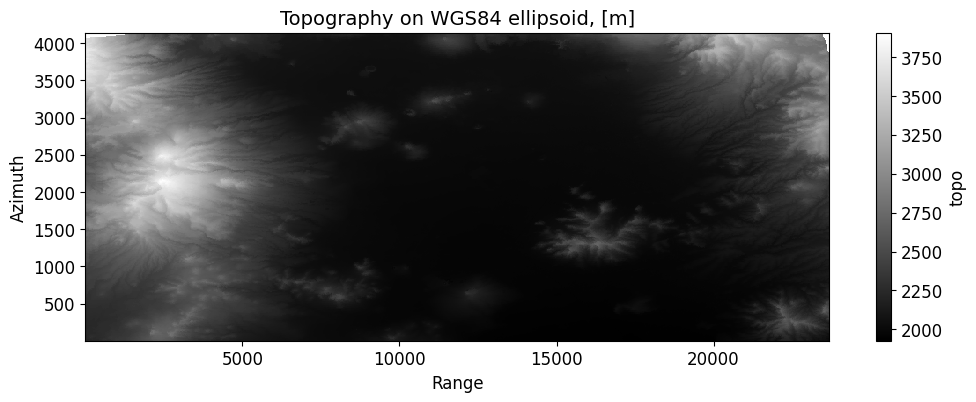

In [115]:
sbas.plot_topo()    #it shows thopography in metres in the grid
plt.savefig('Topography on WGS84 ellipsoid, [m].jpg')

## Multi-Look Interferogram

In [116]:
# for a pair of scenes only two interferograms can be produced
# this one is selected for scenes sorted by the date in direct order
pairs = [sbas.to_dataframe().index]
pairs

[Index(['2016-06-06', '2016-09-10'], dtype='object', name='date')]

In [117]:
sbas.compute_interferogram_multilook(pairs, 'intf_mlook', wavelength=200, psize=64, coarsen=(2,8), resolution=90)
#it produces multilooked interferograms with average phase fifferences between aquisitions

Saving Interferogram 1...1 from 1:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [ ]:
ds60m = sbas.open_stack('intf_mlook')                   #open previous result
intf60m = ds60m.phase[0]                                #select first interferogram phase
corr60m = ds60m.correlation[0]                          #get the coherence map
corr60m

<xarray.DataArray 'correlation' (y: 688, x: 985)> Size: 3MB
dask.array<getitem, shape=(688, 985), dtype=float32, chunksize=(688, 985), chunktype=numpy.ndarray>
Coordinates:
    ref      datetime64[ns] 8B ...
    rep      datetime64[ns] 8B ...
    pair     <U21 84B '2016-06-06 2016-09-10'
  * y        (y) float64 6kB 6.0 12.0 18.0 ... 4.116e+03 4.122e+03 4.128e+03
  * x        (x) float64 8kB 24.0 48.0 72.0 ... 2.359e+04 2.362e+04 2.364e+04

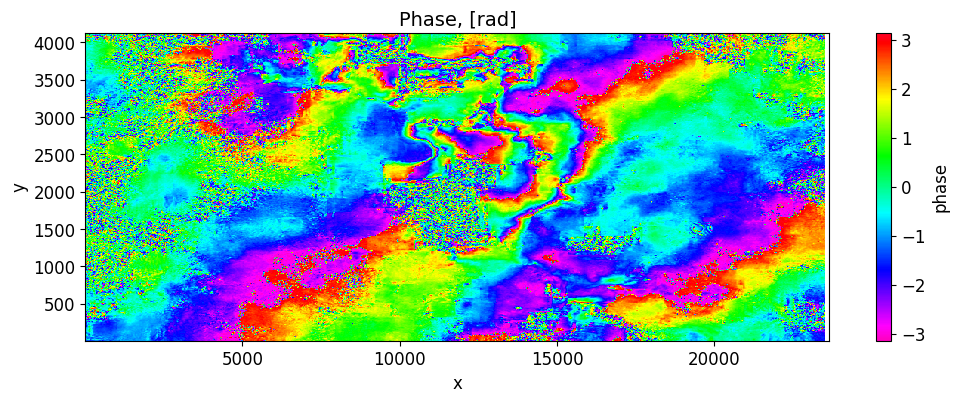

In [119]:
sbas.plot_interferogram(intf60m)   #phase in radians
plt.savefig('Phase, [rad].jpg')

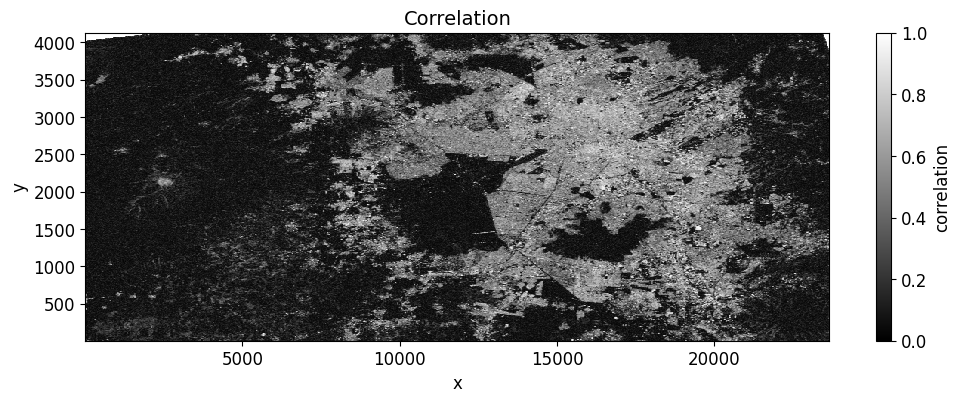

In [120]:
sbas.plot_correlation(corr60m)   #plot the coherence  - higher means more reliable phase
plt.savefig('Correlation.jpg')

In [121]:
sbas.export_vtk(intf60m, 'intf')  #exports to vtk format to use in 3D

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('intf.vtk').scale([1, 1, 0.00002], inplace=True), scalars='phase', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D Interferogram.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive Interferogram on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

In [ ]:
#corr60m.plot.hist(bins=30)
#i used it to see what threshold to use to filter the noise



## Unwrapping

In [123]:
# mask low-coherence areas using threshold value 0.1 - it deletes these areas
tqdm_dask(
    unwrap := sbas.unwrap_snaphu(
        intf60m,                              #the wrapped interferogram
        corr60m.where(corr60m >= 0.17)         #keep these above 0.2
    )
    .where(corr60m >= 0.17)
    .persist(),
    desc='SNAPHU Unwrapping'
)


SNAPHU Unwrapping:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [ ]:
unwrap_ll = sbas.cropna(sbas.ra2ll(unwrap.phase))       #transfer to lon and lat, y and x lim are set to first and last avaible data

In [ ]:
sbas.plot_phase(unwrap_ll, caption='Unwrapped Phase\nGeographic Coordinates, [rad]', quantile=[0.01, 0.99])

## LOS Displacement

In [126]:
# geocode to geographic coordinates and crop empty borders
los_disp_mm_ll = sbas.cropna(sbas.ra2ll(sbas.los_displacement_mm(unwrap.phase)))
#convert unwrapped phase to line-of-sight displacement in millimeters

In [ ]:

los_disp_mm_ll.plot.hist(bins=100, alpha=0.5)    #it shows the histogram of displacements
plt.title('LOS Displacement Histogram, [mm]')
plt.show()

In [ ]:
sbas.plot_displacement(los_disp_mm_ll, caption='LOS Displacement\nGeographic Coordinates, [mm]', vmin=-90, vmax=40)
plt.savefig('LOS Displacement Geographic Coordinates, [mm].jpg')      #here vmin and vmax were changed to see whole scale

In [131]:
sbas.export_vtk(los_disp_mm_ll, 'los')

Exporting WGS84 VTK(s):   0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('los.vtk').scale([1, 1, 0.00002], inplace=True), scalars='los', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D LOS Displacement.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive LOS Displacement on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## Save the Results

Save the results in geospatial data formats like to NetCDF, GeoTIFF and others. The both formats (NetCDF and GeoTIFF) can be opened in QGIS and other GIS applications.

In [ ]:
# save the results
corr60m.to_netcdf('los_disp_mm_ll.nc', engine=sbas.netcdf_engine)

## Export from Google Colab

In [ ]:
if 'google.colab' in sys.modules:
    from google.colab import files
    files.download('los_disp_mm_ll.nc')
    files.download('intf.vtk')
    files.download('los.vtk')

## Conclusion

For now you have the full control on interferometry processing and unwrapping and able to run it everywhere: on free of charge Google Colab instances, on local MacOS and Linux computers and on Amazon EC2 and Google Cloud VM and AI Notebook instances.